# Simulation of an fMRI Timecourse BOLD Response for a Single Voxel

In [1]:
#import needed functions

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nipy.modalities.fmri.hemodynamic_models import spm_hrf, compute_regressor
from statsmodels.tsa.arima_process import arma_generate_sample
from nipy.modalities.fmri.design_matrix import make_dmtx

from nipy.modalities.fmri.experimental_paradigm import (EventRelatedParadigm,
                                                        BlockParadigm)


/home/main/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# frame times
TR= 2
nscans_trial= 30
trial_duration=TR*nscans_trial # 60
ntrials_run= 12
nscans_run=nscans_trial*ntrials_run # 12*30=360
run_duration= TR*nscans_run # 360*2=720

frametimes = np.linspace(0, (nscans_run - 1) * TR, nscans_run)
frametimes

array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
         18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
         36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
         54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
         72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
         90.,   92.,   94.,   96.,   98.,  100.,  102.,  104.,  106.,
        108.,  110.,  112.,  114.,  116.,  118.,  120.,  122.,  124.,
        126.,  128.,  130.,  132.,  134.,  136.,  138.,  140.,  142.,
        144.,  146.,  148.,  150.,  152.,  154.,  156.,  158.,  160.,
        162.,  164.,  166.,  168.,  170.,  172.,  174.,  176.,  178.,
        180.,  182.,  184.,  186.,  188.,  190.,  192.,  194.,  196.,
        198.,  200.,  202.,  204.,  206.,  208.,  210.,  212.,  214.,
        216.,  218.,  220.,  222.,  224.,  226.,  228.,  230.,  232.,
        234.,  236.,  238.,  240.,  242.,  244.,  246.,  248.,  250.,
        252.,  254.,

In [3]:
TR= 2
nscans_trial= 30
trial_duration=TR*nscans_trial # 60
ntrials_run= 12
nscans_run=nscans_trial*ntrials_run # 12*30=360
run_duration= TR*nscans_run # 360*2=720


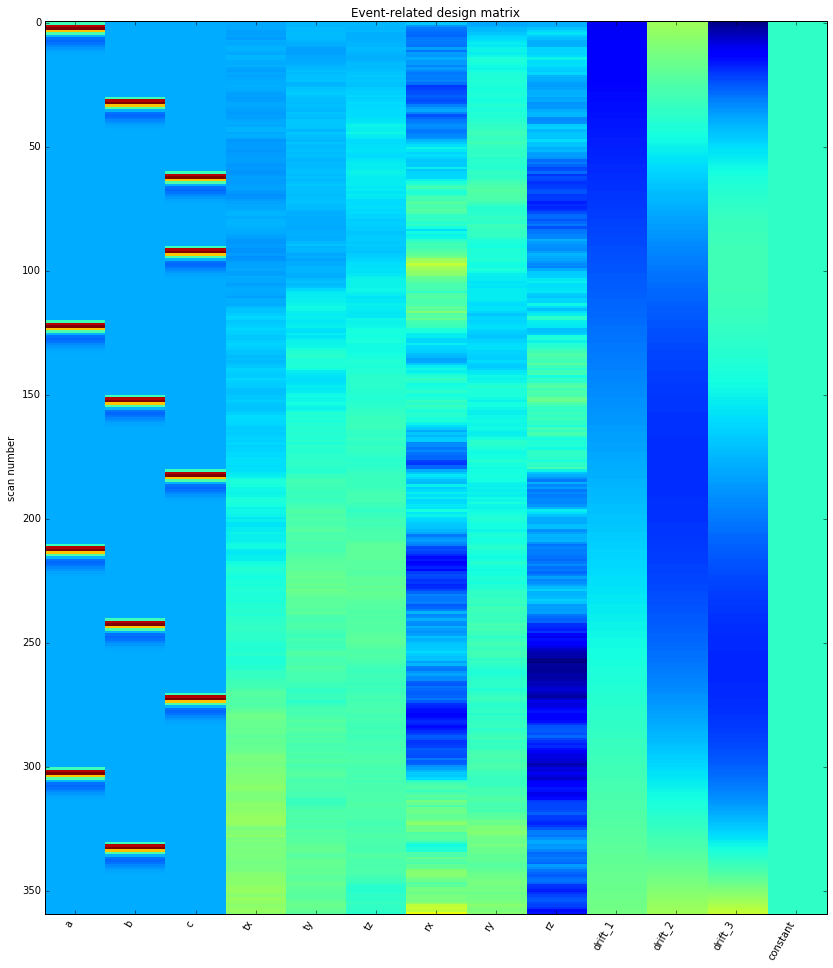

In [4]:

# experimental paradigm
conditions = ['a', 'b', 'c','c', 'a', 'b', 'c', 'a', 'b', 'c','a','b']
#conditions = ['c', 'c', 'c', 'c','c', 'c', 'c', 'c', 'c', 'c', 'c','c']

#onsets = [30, 70, 100, 10, 30, 90, 30, 40, 60]
onsets=np.arange(0,run_duration,trial_duration)

motion = np.cumsum(np.random.randn(nscans_run, 6), 0)
add_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

paradigm = EventRelatedParadigm(conditions, onsets)


#hrf_model = 'fir'
#design_matrix = make_dmtx(frametimes, 
#               paradigm, 
#               hrf_model=hrf_model,
#               drift_model='polynomial', 
#               drift_order=3,
#               fir_delays=np.arange(1, 6))


hrf_model = 'spm'
design_matrix = make_dmtx(frametimes, 
                          paradigm, 
                          hrf_model=hrf_model, 
                          drift_model='polynomial', 
                          drift_order=3, 
                          add_regs=motion, 
                          add_reg_names=add_reg_names)

# plot the matrix

fig = plt.figure(figsize=(14, 16))
ax = plt.subplot(1, 1, 1)
design_matrix.show(ax=ax)
ax.set_title('Event-related design matrix', fontsize=12)


In [6]:
# generate the errors (AR1)
ar = [1, 0.5]
ma = [1, 0.0] 
epsilon_ar1= arma_generate_sample(ar,ma,nscans_run)

# generate the data
noise_scale = 0.3
activation_param = [90.0,60.0,30.0]
motion_param = [.00,.00,.00,.00,.00,.00] # ignore
drift_param = [0.0,0.0,0.0] # ignore
constant_param= [0.0] # zero mean centered
#concatenate cofficients
Beta =np.array([activation_param +motion_param+ drift_param+ constant_param])
# generate BOLD response timecourse for a single voxel
y=np.dot(Beta,design_matrix.matrix.T) + epsilon_ar1*noise_scale

## Plot the Timecourse

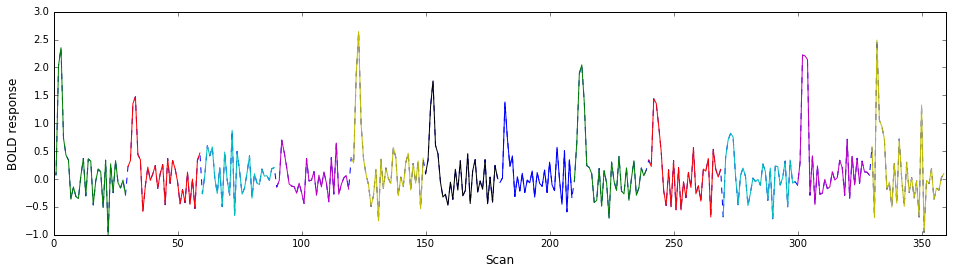

In [8]:
#plot timecourse for one voxel

plt.figure(figsize=(16,4))
plt.axis([0,nscans_run,-1.,3.])
plt.plot(y.T,'--')
plt.xlabel('Scan',fontsize=12)
plt.ylabel('BOLD response',fontsize=12)
for i in onsets/2:
    plt.plot(np.arange(i,i+nscans_trial),y.T[i:i+nscans_trial])


## Plot the Trials 

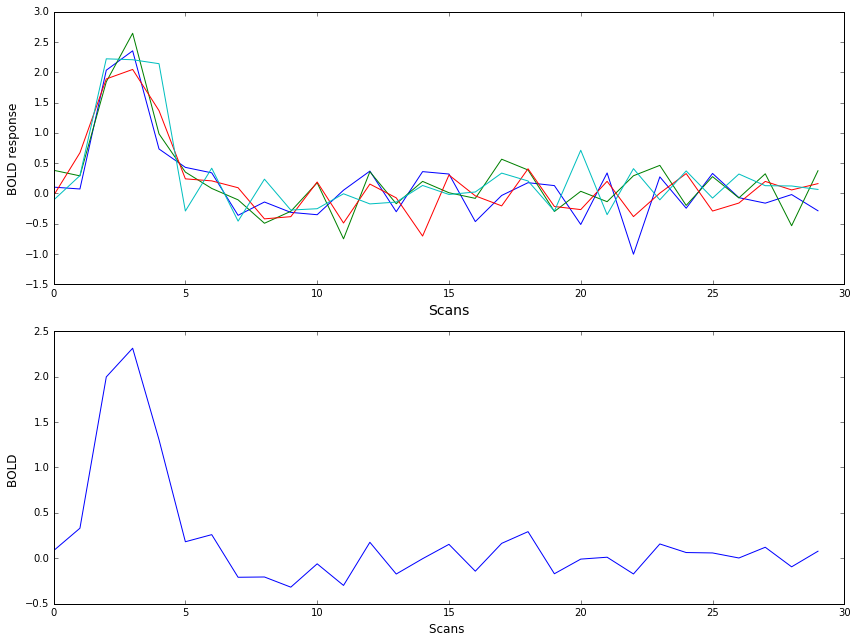

In [10]:

# conditions a 
time_onsets =onsets[[i for i, j in enumerate(conditions) if j == 'a']]/2
y_cond_a=y.T[time_onsets[0]:time_onsets[0]+nscans_trial] 

for i in time_onsets[1:]:
    y_cond_a=np.hstack((y_cond_a,y.T[i:i+nscans_trial]))
    
plt.figure(figsize=(12,9))
plt.axis([0,nscans_run,-1.,3.])       
plt.subplot(2,1,1)
plt.plot(y_cond_a)
plt.xlabel('Scans',fontsize=14)
plt.ylabel('BOLD response',fontsize=12)
plt.subplot(2,1,2)
plt.plot(np.mean(y_cond_a,1))
plt.xlabel('Scans ',fontsize=12)
plt.ylabel('BOLD ',fontsize=12)
plt.tight_layout()

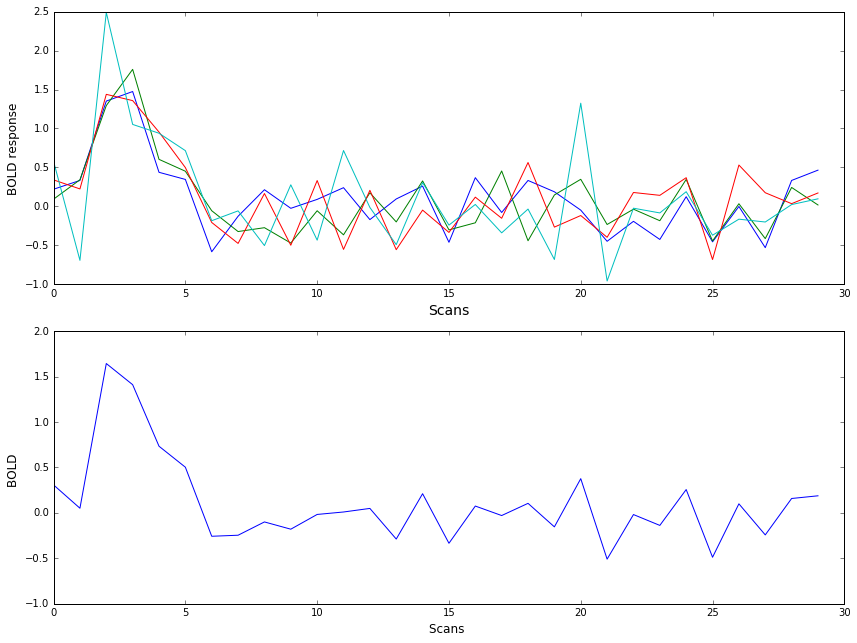

In [13]:
# conditions b 
time_onsets =onsets[[i for i, j in enumerate(conditions) if j == 'b']]/2
y_cond_b=y.T[time_onsets[0]:time_onsets[0]+nscans_trial] 

for i in time_onsets[1:]:
    y_cond_b=np.hstack((y_cond_b,y.T[i:i+nscans_trial]))
    
plt.figure(figsize=(12,9))
plt.axis([0,nscans_run,-1.,3.])       
plt.subplot(2,1,1)
plt.plot(y_cond_b)
plt.xlabel('Scans',fontsize=14)
plt.ylabel('BOLD response',fontsize=12)
plt.subplot(2,1,2)
plt.plot(np.mean(y_cond_b,1))
plt.xlabel('Scans ',fontsize=12)
plt.ylabel('BOLD ',fontsize=12)
plt.tight_layout()

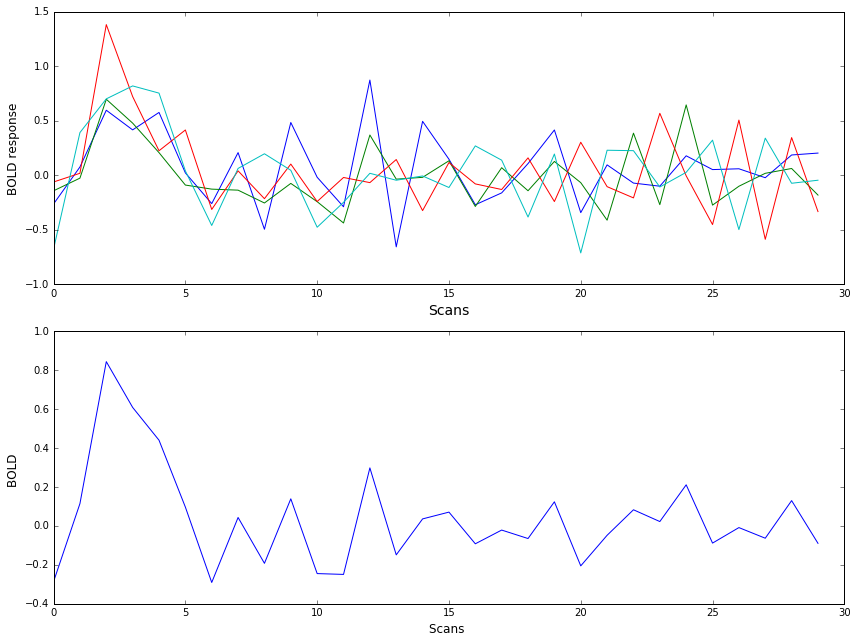

In [12]:
# conditions c 

time_onsets =onsets[[i for i, j in enumerate(conditions) if j == 'c']]/2
y_cond_c=y.T[time_onsets[0]:time_onsets[0]+nscans_trial] 

for i in time_onsets[1:]:
    y_cond_c=np.hstack((y_cond_c,y.T[i:i+nscans_trial]))
    
plt.figure(figsize=(12,9))
plt.axis([0,nscans_run,-1.,3.])       
plt.subplot(2,1,1)
plt.plot(y_cond_c)
plt.xlabel('Scans',fontsize=14)
plt.ylabel('BOLD response',fontsize=12)
plt.subplot(2,1,2)
plt.plot(np.mean(y_cond_c,1))
plt.xlabel('Scans ',fontsize=12)
plt.ylabel('BOLD ',fontsize=12)
plt.tight_layout()